# Libraries 📚

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import time

# IPNYB
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Model and performance
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer

2023-07-04 07:31:54.466792: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 07:31:54.532319: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-04 07:31:54.533379: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 07:31:55.233268: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Code 💻

## Functions

In [2]:
def load_select_resolution(dx=0.1, dy=0.1):
        '''
        Selects the resolution of the matrices to load.
        dx: the x resolution
        dy: the y resolution
        return: None
        '''
        if dx == 0.1 and dy == 0.1:
                # Load matrices from previously generated files
                X_01 = np.load('matrices/X_01.npy')
                y_01 = np.load('matrices/y_01.npy')
                print(f'Matrix shapes -> X: {X_01.shape}, y: {y_01.shape}')
                return X_01, y_01
                        
        elif dx == 0.3 and dy == 0.3:
                # Load matrices from previously generated files
                X_03 = np.load('matrices/X_03.npy')
                y_03 = np.load('matrices/y_03.npy')
                nX = np.load('matrices/nX.npy')
                ny = np.load('matrices/ny.npy')
                print(f'Matrix shapes -> X: {X_03.shape}, y: {y_03.shape}, nX: {nX.shape}, ny: {ny.shape}')
                return X_03, y_03, nX, ny

def tts(X, y, nX=None, ny=None, dx=0.1, dy=0.1):
        # Muons --------------------------------------------------------------
        print('Muons:')
        # Use X and y to recover the muon events
        muons = X[y == 1]
        muon_labels = y[y == 1]

        # Train test split for muon data
        mX_train, mX_test, my_train, my_test = train_test_split(muons, muon_labels, test_size=0.2)
        mX_train, mX_val, my_train, my_val = train_test_split(mX_train, my_train, test_size=0.2)

        # Normalizing the data
        # We will use the function normalize from keras.utils to normalize the data.
        # We will normalize the data by dividing the data by the maximum value of the data.
        mX_train = keras.utils.normalize(mX_train, axis=1)
        mX_val = keras.utils.normalize(mX_val, axis=1)
        mX_test = keras.utils.normalize(mX_test, axis=1)

        # Reshape the y data to be a column one-hot encoded vector.
        my_train = keras.utils.to_categorical(my_train, 2)
        my_val = keras.utils.to_categorical(my_val, 2)
        my_test = keras.utils.to_categorical(my_test, 2)

        # Check the number of records
        print('The number of records in the training dataset is', mX_train.shape[0])
        print('The number of records in the test dataset is', mX_test.shape[0])
        print(f"Muon shapes: Train: {mX_train.shape}, Val: {mX_val.shape}, Test: {mX_test.shape}, Train labels: {my_train.shape}, Val labels: {my_val.shape}, Test labels: {my_test.shape}")
        print(f"Muon target training vector: {my_train}") # Show target vector (01 = muon, 10 = antimuon)
        print(' ')
        print(' ')

        # Antimuons --------------------------------------------------------------
        print('Antimuons')
        # Use X and y to recover the antimuon events
        antimuons = X[y == 0]
        antimuon_labels = y[y == 0]

        # Train test split for antimuon data
        aX_train, aX_test, ay_train, ay_test = train_test_split(antimuons, antimuon_labels, test_size=0.2)
        aX_train, aX_val, ay_train, ay_val = train_test_split(aX_train, ay_train, test_size=0.2)

        # Normalizing the data
        # We will use the function normalize from keras.utils to normalize the data.
        # We will normalize the data by dividing the data by the maximum value of the data.
        aX_train = keras.utils.normalize(aX_train, axis=1)
        aX_val = keras.utils.normalize(aX_val, axis=1)
        aX_test = keras.utils.normalize(aX_test, axis=1)

        # Reshape the y data to be a column one-hot encoded vector.
        ay_train = keras.utils.to_categorical(ay_train, 2)
        ay_val = keras.utils.to_categorical(ay_val, 2)
        ay_test = keras.utils.to_categorical(ay_test, 2)

        # Check the number of records
        print('The number of records in the training dataset is', aX_train.shape[0])
        print('The number of records in the test dataset is', aX_test.shape[0])
        print(f"Antimuon shapes: Train: {aX_train.shape}, Val: {aX_val.shape}, Test: {aX_test.shape}, Train labels: {ay_train.shape}, Val labels: {ay_val.shape}, Test labels: {ay_test.shape}")
        print(f"Antimuon target training vector: {ay_train}") # Show target vector (01 = muon, 10 = antimuon)
        
        if dx == 0.3 and dy == 0.3 and nX is not None and ny is not None:
                print(' ')
                print(' ')
                
                # Neutrons --------------------------------------------------------------
                print('Neutrons')
                
                # Normalizing the data
                # We will use the function normalize from keras.utils to normalize the data.
                # We will normalize the data by dividing the data by the maximum value of the data.
                nX = keras.utils.normalize(nX, axis=1)
                
                # Check the number of records
                print(f"Neutron shapes: {nX.shape, ny.shape}")
                return mX_train, mX_val, mX_test, my_train, my_val, my_test, aX_train, aX_val, aX_test, ay_train, ay_val, ay_test, nX, ny
        
        else:
                return mX_train, mX_val, mX_test, my_train, my_val, my_test, aX_train, aX_val, aX_test, ay_train, ay_val, ay_test

def autoencoder_model(X_train, X_val, modelnumber):
        '''
        Chooses the model number and returns the trained model
        X_train: the training set
        X_val: the validation set
        modelnumber: the model number
        return: the trained model
        '''
        if modelnumber == 1:
                # We will train the autoencoder model using only the muon training set.
                MATRIX_SHAPE = X_train.shape[1:]

                # Input layer: the input are images with two channels (side 1 and side 2), each image has a 7x5 resolution (7,5,2)
                input = tf.keras.layers.Input(shape=(MATRIX_SHAPE))
                activation_function = 'relu'

                # Encoder layers
                encoder = tf.keras.Sequential([
                layers.Flatten(),
                layers.Dense(np.prod(MATRIX_SHAPE), activation=activation_function),
                layers.Dense(X_train.shape[1]*X_train.shape[2], activation=activation_function),
                layers.Dense(X_train.shape[1], activation=activation_function),
                layers.Dense(X_train.shape[2], activation=activation_function)])(input)

                # Decoder layers
                decoder = tf.keras.Sequential([
                layers.Dense(X_train.shape[2], activation=activation_function),
                layers.Dense(X_train.shape[1], activation=activation_function),
                layers.Dense(X_train.shape[1]*X_train.shape[2], activation=activation_function),
                layers.Dense(np.prod(MATRIX_SHAPE), activation=activation_function),
                layers.Reshape(MATRIX_SHAPE)])(encoder)

                # Create the autoencoder
                autoencoder = Model(input, decoder)

                # Compile the autoencoder
                autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
                
                # Save the model
                autoencoder.save(f'models/autoencoder_{modelnumber}.h5')
                
                # Print the summary of the autoencoder
                print(autoencoder.summary())

                # Fit the autoencoder
                start = time.time()
                history = autoencoder.fit(X_train, X_train, 
                        epochs=30, 
                        validation_data=(X_val, X_val),
                        shuffle=True)
                end = time.time()
                print('Training time:', end - start)

                # Plotting the training and validation loss and accuracy
                fig, axs = plt.subplots(1, 2, figsize=(15, 7))
                axs[0].plot(history.history['loss'], label='Training loss')
                axs[0].plot(history.history['val_loss'], label='Validation loss')
                axs[0].set_title('Training and validation loss')
                axs[0].set_xlabel('Epoch')
                axs[0].set_ylabel('Loss')
                axs[0].legend()
                axs[1].plot(history.history['accuracy'], label='Training accuracy')
                axs[1].plot(history.history['val_accuracy'], label='Validation accuracy')
                axs[1].set_title('Training and validation accuracy')
                axs[1].set_xlabel('Epoch')
                axs[1].set_ylabel('Accuracy')
                axs[1].legend()
                plt.show()
                return autoencoder
        
        elif modelnumber == 2:
                def build_autoencoder(img_shape, code_size, activation_function):
                        # Encoder
                        encoder = Sequential()
                        encoder.add(InputLayer(img_shape))
                        encoder.add(Flatten())
                        encoder.add(Dense(code_size, activation=activation_function))
                        
                        # Decoder
                        decoder = Sequential()
                        decoder.add(InputLayer((code_size,)))
                        decoder.add(Dense(np.prod(img_shape), activation=activation_function)) # np.prod(img_shape) is the same as 7*5*2, it's more generic than saying 70
                        decoder.add(Reshape(img_shape))
                        return encoder, decoder

                MATRIX_SHAPE = X_train.shape[1:]
                print(Input(MATRIX_SHAPE))
                activation_function = 'relu'
                encoder, decoder = build_autoencoder(MATRIX_SHAPE, 32, activation_function)

                inp = Input(MATRIX_SHAPE)
                code = encoder(inp)
                reconstruction = decoder(code)

                autoencoder = Model(inp, reconstruction)
                autoencoder.compile(optimizer='adam', loss='mse', metrics="accuracy")
                
                # Save the model
                autoencoder.save(f'models/autoencoder_{modelnumber}.h5')
                
                # Print the summary of the autoencoder
                print(autoencoder.summary())

                # Fit the autoencoder
                start = time.time()
                history = autoencoder.fit(X_train, X_train, 
                        epochs=30, 
                        validation_data=(X_val, X_val),
                        shuffle=True)
                end = time.time()
                print('Training time:', end - start)

                # Plotting the training and validation loss and accuracy
                fig, axs = plt.subplots(1, 2, figsize=(15, 7))
                axs[0].plot(history.history['loss'], label='Training loss')
                axs[0].plot(history.history['val_loss'], label='Validation loss')
                axs[0].set_title('Training and validation loss')
                axs[0].set_xlabel('Epoch')
                axs[0].set_ylabel('Loss')
                axs[0].legend()
                axs[1].plot(history.history['accuracy'], label='Training accuracy')
                axs[1].plot(history.history['val_accuracy'], label='Validation accuracy')
                axs[1].set_title('Training and validation accuracy')
                axs[1].set_xlabel('Epoch')
                axs[1].set_ylabel('Accuracy')
                axs[1].legend()
                plt.show()
                return autoencoder      

def reconstruction_error_plot(model, X_test, aX_test, nX=None):
        '''
        Shows a plot of the reconstruction error for muons and antimuons. Neutrons are optional.
        model: the autoencoder model
        X_test: the muon test set
        aX_test: the antimuon test set
        nX: the neutron set (optional)
        return: None
        '''
        
        # Predict on the test set
        X_test_pred = model.predict(X_test)
        aX_test_pred = model.predict(aX_test)

        # Calculate the mean squared error
        X_test_pred_mse_loss = tf.keras.losses.mse(X_test_pred, X_test)
        aX_test_pred_mse_loss = tf.keras.losses.mse(aX_test_pred, aX_test)

        # Mean over the side and channel axes
        X_test_pred_mse_loss = np.mean(X_test_pred_mse_loss, axis=(1,2))
        aX_test_pred_mse_loss = np.mean(aX_test_pred_mse_loss, axis=(1,2))
        
        # Plot the distribution of the reconstruction loss
        plt.figure(figsize=(10, 7))
        plt.scatter(range(len(X_test_pred_mse_loss)), X_test_pred_mse_loss, color='red', label='Reconstruction loss muons')
        plt.scatter(range(len(aX_test_pred_mse_loss)), aX_test_pred_mse_loss, color='blue', label='Reconstruction loss antimuons')
        
        if nX is not None:
            nX_pred = model.predict(nX)
            nX_pred_mse_loss = tf.keras.losses.mse(nX_pred, nX)
            nX_pred_mse_loss = np.mean(nX_pred_mse_loss, axis=(1,2))
            plt.scatter(range(len(nX_pred_mse_loss)), nX_pred_mse_loss, color='green', label='Reconstruction loss neutrons')
            
        plt.xlabel('Event')
        plt.ylabel('Mean Squared Error')
        plt.title('MSE Error Reconstruction')
        plt.legend()
        plt.show()
        return None

def reconstruction_error(model, X_test, aX_test, nX=None):
        '''
        Returns a tuple with the reconstruction error for muons and antimuons. Neutrons are optional.
        model: the autoencoder model
        X_test: the muon test set
        aX_test: the antimuon test set
        nX: the neutron set (optional)
        return: tuple
                if nX is None: (X_test_pred_mse_loss, aX_test_pred_mse_loss)
                else: (X_test_pred_mse_loss, aX_test_pred_mse_loss, nX_pred_mse_loss)
        '''
        # Predict on the test set
        X_test_pred = model.predict(X_test)
        aX_test_pred = model.predict(aX_test)
        
        # Calculate the mean squared error
        X_test_pred_mse_loss = tf.keras.losses.mse(X_test_pred, X_test)
        aX_test_pred_mse_loss = tf.keras.losses.mse(aX_test_pred, aX_test)

        # Mean over the side and channel axes
        X_test_pred_mse_loss = np.mean(X_test_pred_mse_loss, axis=(1,2))
        aX_test_pred_mse_loss = np.mean(aX_test_pred_mse_loss, axis=(1,2))
        
        if nX is not None:
            nX_pred = model.predict(nX)
            nX_pred_mse_loss = tf.keras.losses.mse(nX_pred, nX)
            nX_pred_mse_loss = np.mean(nX_pred_mse_loss, axis=(1,2))
            
        return (X_test_pred_mse_loss, aX_test_pred_mse_loss, nX_pred_mse_loss) if nX is not None else (X_test_pred_mse_loss, aX_test_pred_mse_loss)

def particle_compare_plot(pX_test, pX_test_pred, py_test=None):
        random_events = np.random.randint(0, pX_test.shape[0], 1)
        print(f'Event number: {random_events}')

        for i in random_events:
                fig, axs = plt.subplots(1, 4, figsize=(20, 7))
                
                if py_test is not None:
                        # Event
                        axs[0].imshow(pX_test[i,:,:,0], cmap='Reds')
                        axs[0].set_title('Muon' if py_test[i][0] == 0 else 'Antimuon')
                        axs[1].imshow(pX_test[i,:,:,1], cmap='Blues')
                        axs[1].set_title('Muon' if py_test[i][0] == 0 else 'Antimuon')
                        
                        # Reconstructed event
                        axs[2].imshow(pX_test_pred[i,:,:,0], cmap='Reds')
                        axs[2].set_title('Muon - Reconstruction' if py_test[i][0] == 0 else 'Antimuon - Reconstruction')
                        axs[3].imshow(pX_test_pred[i,:,:,1], cmap='Blues')
                        axs[3].set_title('Muon - Reconstruction' if py_test[i][0] == 0 else 'Antimuon - Reconstruction')
                        
                        # Show tick labels on both sides
                        axs[0].tick_params('x', labelbottom=True, labeltop=True)
                        axs[0].tick_params('y', labelleft=True, labelright=True)
                        axs[0].set_xlabel('Side 1')
                        
                        axs[1].tick_params('x', labelbottom=True, labeltop=True)
                        axs[1].tick_params('y', labelleft=True, labelright=True)
                        axs[1].set_xlabel('Side 2')
                        
                        # Show tick labels on both sides
                        axs[2].tick_params('x', labelbottom=True, labeltop=True)
                        axs[2].tick_params('y', labelleft=True, labelright=True)
                        axs[2].set_xlabel('Side 1')
                        
                        axs[3].tick_params('x', labelbottom=True, labeltop=True)
                        axs[3].tick_params('y', labelleft=True, labelright=True)
                        axs[3].set_xlabel('Side 2')
                        
                        plt.show()
                
                else:   
                        # Event
                        axs[0].imshow(pX_test[i,:,:,0], cmap='Reds')
                        axs[0].set_title('Neutron')
                        axs[1].imshow(pX_test[i,:,:,1], cmap='Blues')
                        axs[1].set_title('Neutron')

                        # Reconstructed event
                        axs[2].imshow(pX_test_pred[i,:,:,0], cmap='Reds')
                        axs[2].set_title('Neutron')
                        axs[3].imshow(pX_test_pred[i,:,:,1], cmap='Blues')
                        axs[3].set_title('Neutron')

                        # Show tick labels on both sides
                        axs[0].tick_params('x', labelbottom=True, labeltop=True)
                        axs[0].tick_params('y', labelleft=True, labelright=True)
                        axs[0].set_xlabel('Side 1')

                        axs[1].tick_params('x', labelbottom=True, labeltop=True)
                        axs[1].tick_params('y', labelleft=True, labelright=True)
                        axs[1].set_xlabel('Side 2')

                        # Show tick labels on both sides
                        axs[2].tick_params('x', labelbottom=True, labeltop=True)
                        axs[2].tick_params('y', labelleft=True, labelright=True)
                        axs[2].set_xlabel('Side 1 - Reconstruction')

                        axs[3].tick_params('x', labelbottom=True, labeltop=True)
                        axs[3].tick_params('y', labelleft=True, labelright=True)
                        axs[3].set_xlabel('Side 2 - Reconstruction')
                        
                        plt.show()
        

## Load Data (0.1)

In [3]:
dx = 0.1
dy = 0.1

X, y = load_select_resolution(dx, dy)
mX_train, mX_val, mX_test, my_train, my_val, my_test, aX_train, aX_val, aX_test, ay_train, ay_val, ay_test = tts(X, y)

Matrix shapes -> X: (10233, 21, 15, 2), y: (10233,)
Muons:
The number of records in the training dataset is 3336
The number of records in the test dataset is 1043
Muon shapes: Train: (3336, 21, 15, 2), Val: (835, 21, 15, 2), Test: (1043, 21, 15, 2), Train labels: (3336, 2), Val labels: (835, 2), Test labels: (1043, 2)
Muon target training vector: [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
 
 
Antimuons
The number of records in the training dataset is 3212
The number of records in the test dataset is 1004
Antimuon shapes: Train: (3212, 21, 15, 2), Val: (803, 21, 15, 2), Test: (1004, 21, 15, 2), Train labels: (3212, 2), Val labels: (803, 2), Test labels: (1004, 2)
Antimuon target training vector: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


### Plot random event

[904]


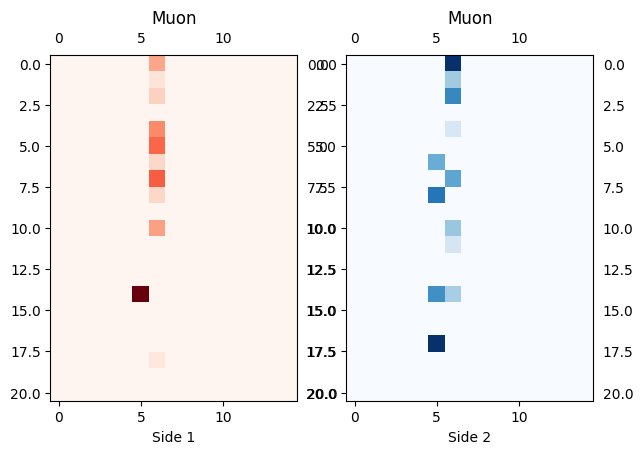

In [4]:
# Plotting a muon event from the training set.
random_events = np.random.randint(0, mX_train.shape[0], 1)
print(random_events)

for i in random_events:
        fig, axs = plt.subplots(1, 2, figsize=(7, 7))
        axs[0].imshow(mX_train[i,:,:,0], cmap='Reds')
        axs[0].set_title('Muon' if my_train[i][0] == 0 else 'Antimuon')
        axs[1].imshow(mX_train[i,:,:,1], cmap='Blues')
        axs[1].set_title('Muon' if my_train[i][0] == 0 else 'Antimuon')
        # Show tick labels on both sides
        axs[0].tick_params('x', labelbottom=True, labeltop=True)
        axs[0].tick_params('y', labelleft=True, labelright=True)
        axs[1].tick_params('x', labelbottom=True, labeltop=True)
        axs[1].tick_params('y', labelleft=True, labelright=True)
        axs[0].set_xlabel('Side 1')
        axs[1].set_xlabel('Side 2')
plt.show()

## Autoencoder 1

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 15, 2)]       0         
                                                                 
 sequential (Sequential)     (None, 15)                603261    
                                                                 
 sequential_1 (Sequential)   (None, 21, 15, 2)         206586    
                                                                 
Total params: 809,847
Trainable params: 809,847
Non-trainable params: 0
_________________________________________________________________


2023-07-04 07:31:57.040357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-04 07:31:57.040849: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
105/105 [==============================] - 2s 11ms/step - loss: 0.0071 - accuracy: 0.8074 - val_loss: 0.0061 - val_accuracy: 0.8941
Epoch 2/30
105/105 [==============================] - 1s 9ms/step - loss: 0.0059 - accuracy: 0.9261 - val_loss: 0.0053 - val_accuracy: 0.9401
Epoch 3/30
105/105 [==============================] - 1s 8ms/step - loss: 0.0052 - accuracy: 0.9475 - val_loss: 0.0049 - val_accuracy: 0.9508
Epoch 4/30
105/105 [==============================] - 1s 9ms/step - loss: 0.0048 - accuracy: 0.9543 - val_loss: 0.0046 - val_accuracy: 0.9525
Epoch 5/30
105/105 [==============================] - 1s 10ms/step - loss: 0.0046 - accuracy: 0.9573 - val_loss: 0.0045 - val_accuracy: 0.9557
Epoch 6/30
105/105 [==============================] - 1s 10ms/step - loss: 0.0044 - accuracy: 0.9597 - val_loss: 0.0044 - val_accuracy: 0.9592
Epoch 7/30
105/105 [==============================] - 1s 10ms/step - loss: 0.0043 - accuracy: 0.9603 - val_loss: 0.0043 - val_accuracy: 0.9600
Ep

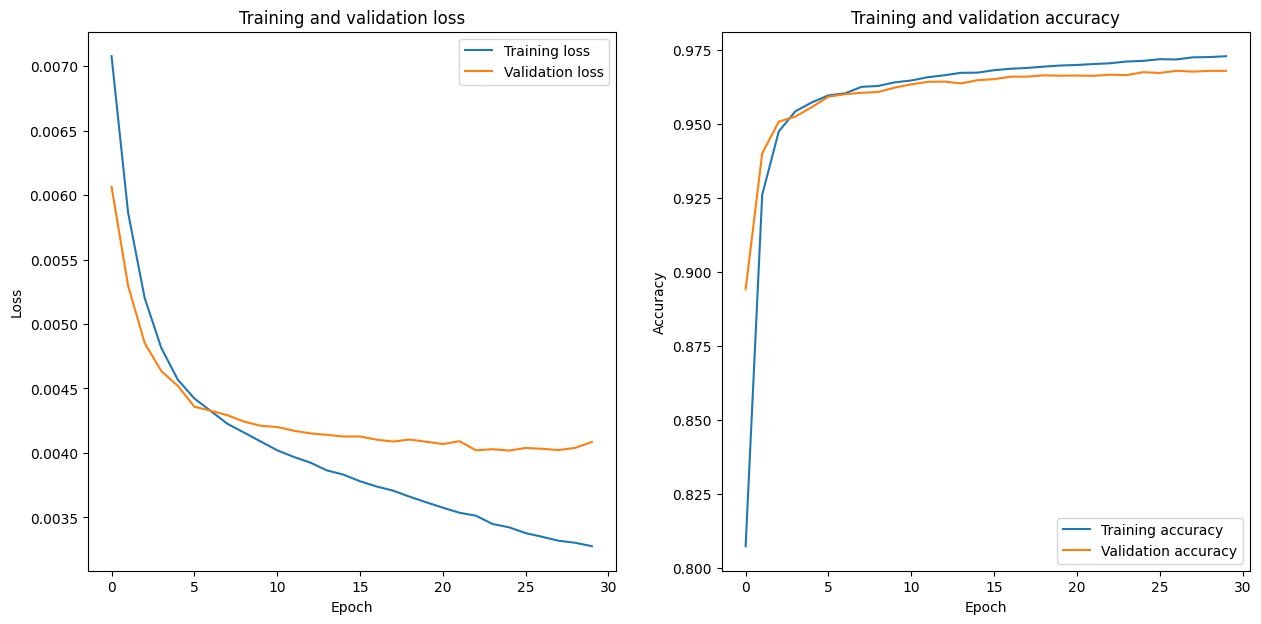

In [5]:
autoencoder = autoencoder_model(mX_train, mX_val, 1)

### MSE Reconstruction Error 1

32/32 [==============================] - 0s 3ms/step


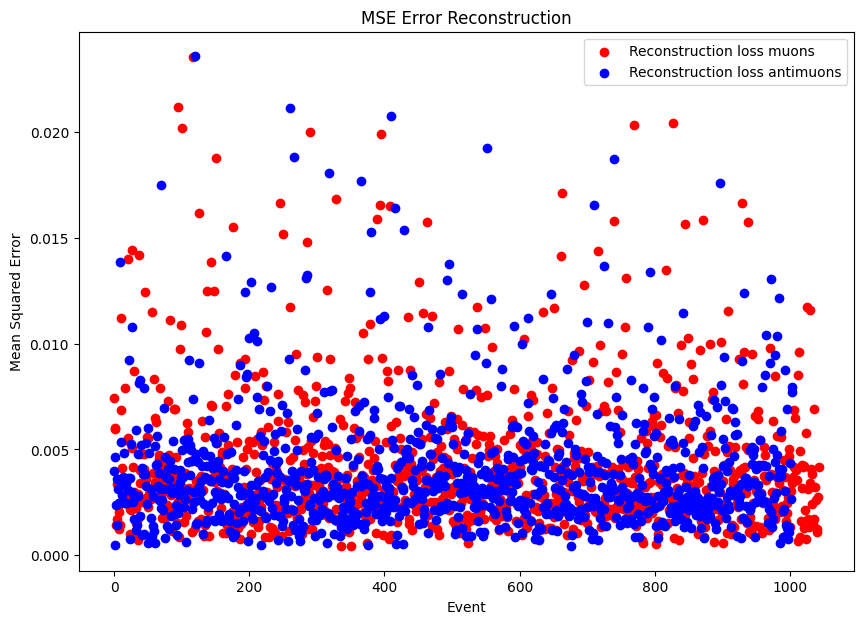

In [6]:
# Plot the difference between the input and the reconstructed output, we want to make sure that data is not separable so we feed the antimuon data to the autoencoder.
# We expect the reconstructed output caused by antimuon data to be non differentiable from the input.
reconstruction_error_plot(autoencoder, mX_test, aX_test)

### Comparing original vs reconstructed particle showers (AE1 0.1)

#### Muon

33/33 [==============================] - 0s 2ms/step
Event number: [84]


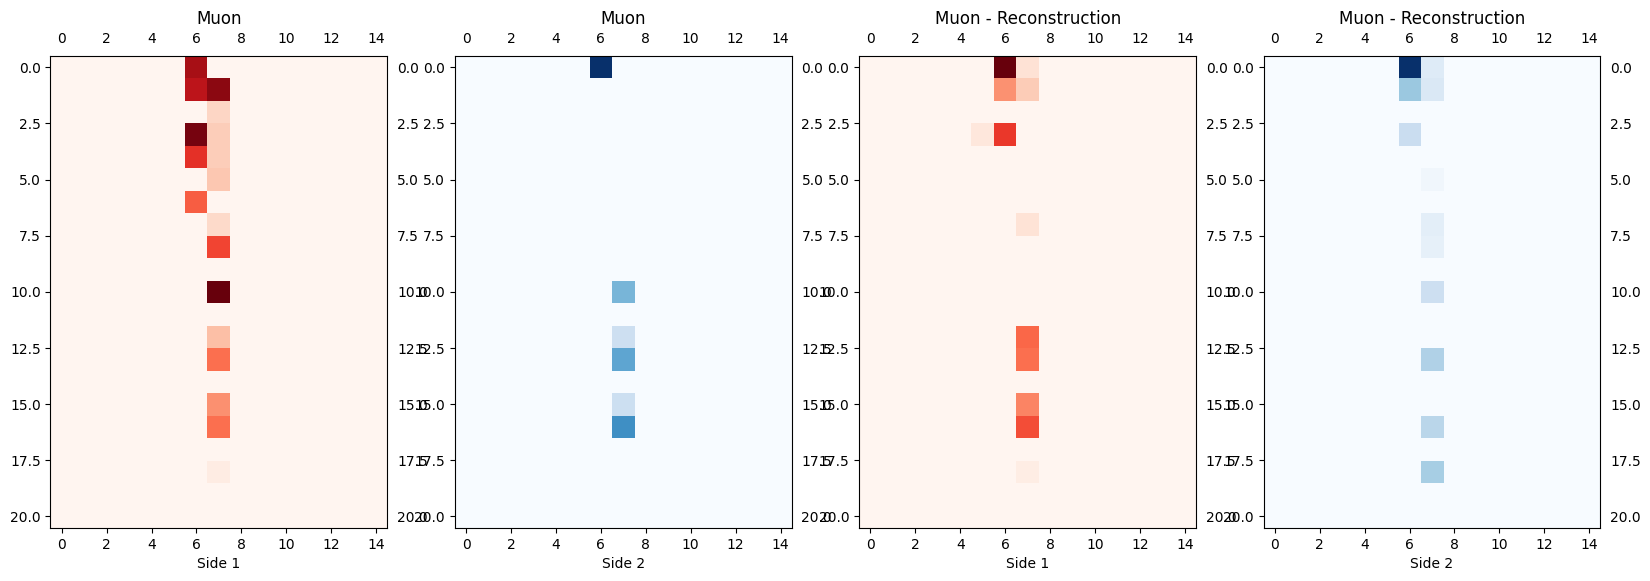

In [7]:
particle_compare_plot(mX_test, autoencoder.predict(mX_test), my_test)

#### Antimuon

 1/32 [..............................] - ETA: 0s

32/32 [==============================] - 0s 2ms/step
Event number: [223]


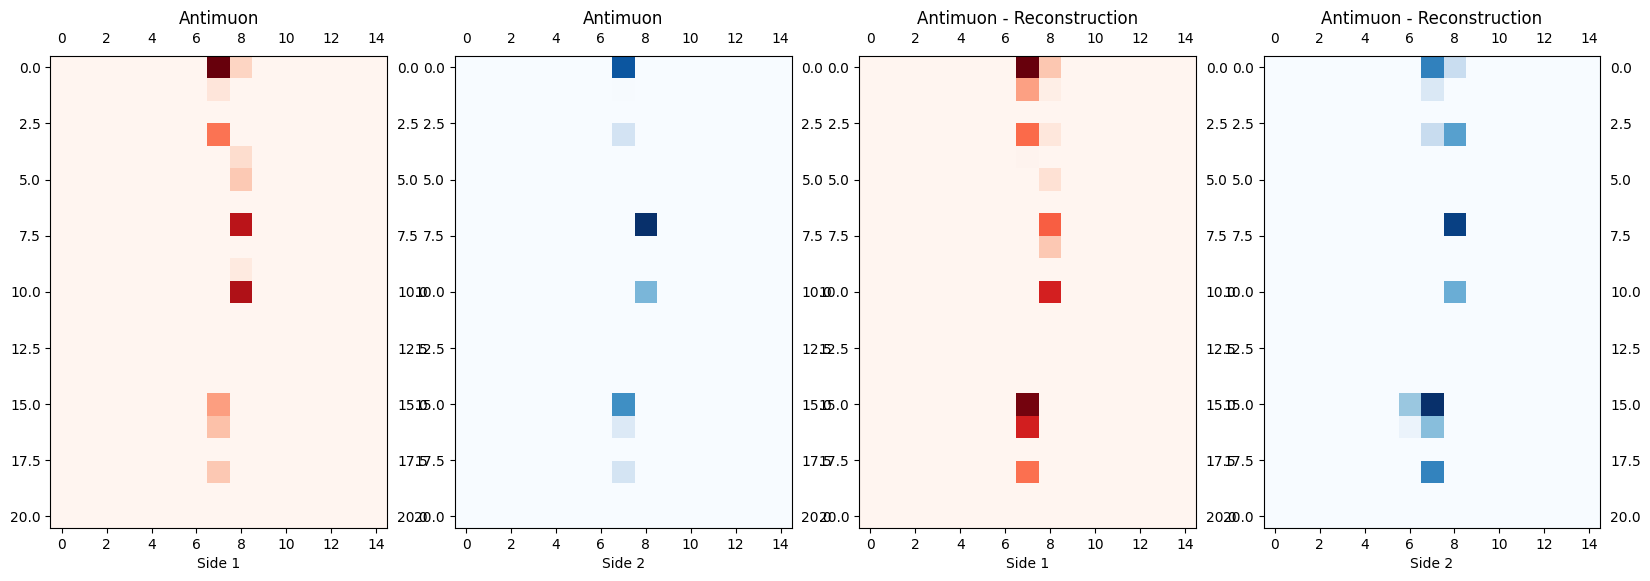

In [8]:
particle_compare_plot(aX_test, autoencoder.predict(aX_test), ay_test)

## Autoencoder 2

KerasTensor(type_spec=TensorSpec(shape=(None, 21, 15, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 21, 15, 2)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 32)                20192     
                                                                 
 sequential_3 (Sequential)   (None, 21, 15, 2)         20790     
                                                                 
Total params: 40,982
Trainable params: 40,982
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
105/105 [==============================] - 1s 3ms/step - loss: 0.0069 - accuracy: 0.7919 - val_loss: 0.0055 - val_accuracy: 0.8813
Epoch 2/30
105/105 [=

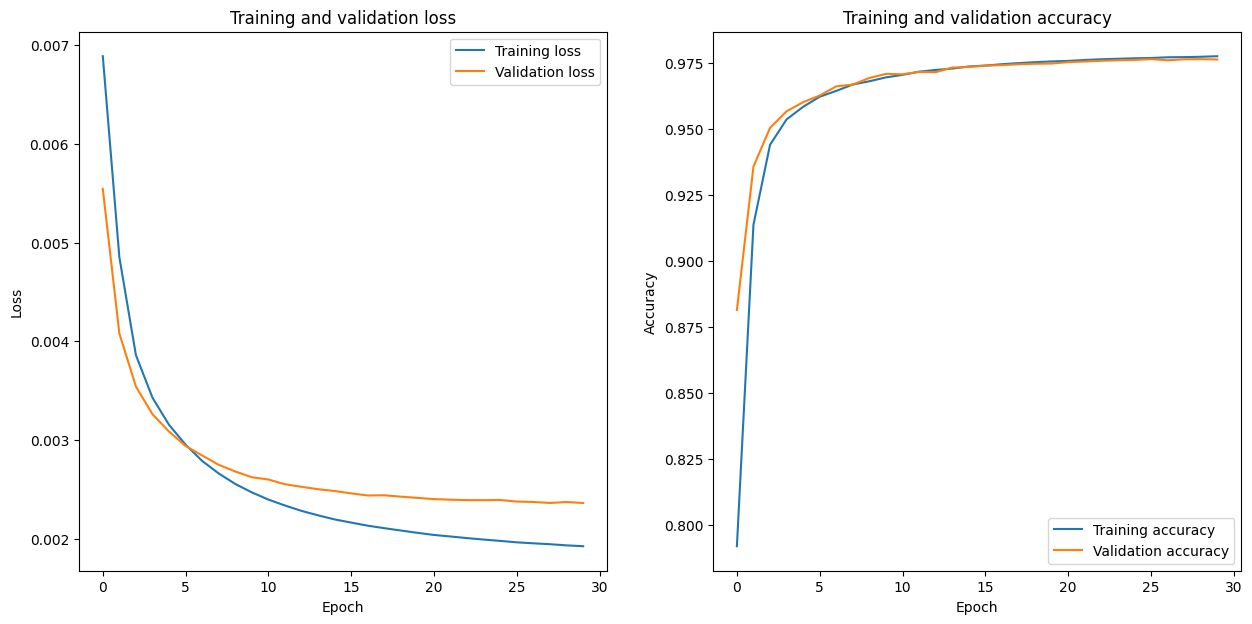

In [9]:
autoencoder = autoencoder_model(mX_train, mX_val, 2)

### MSE Reconstruction Error 2

32/32 [==============================] - 0s 1ms/step


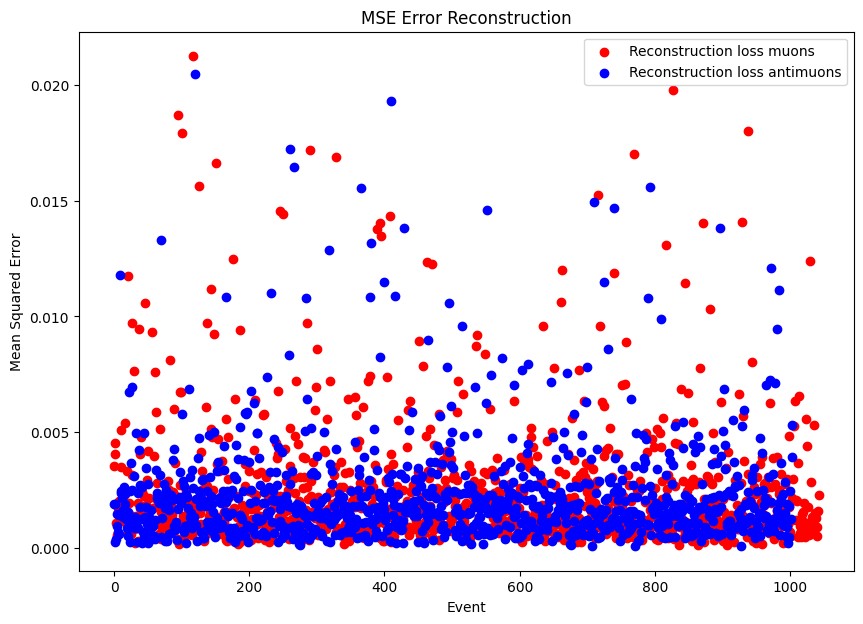

In [10]:
reconstruction_error_plot(autoencoder, mX_test, aX_test)

### Comparing original vs reconstructed particle showers (AE2 0.1)

#### Muon

33/33 [==============================] - 0s 1ms/step
Event number: [527]


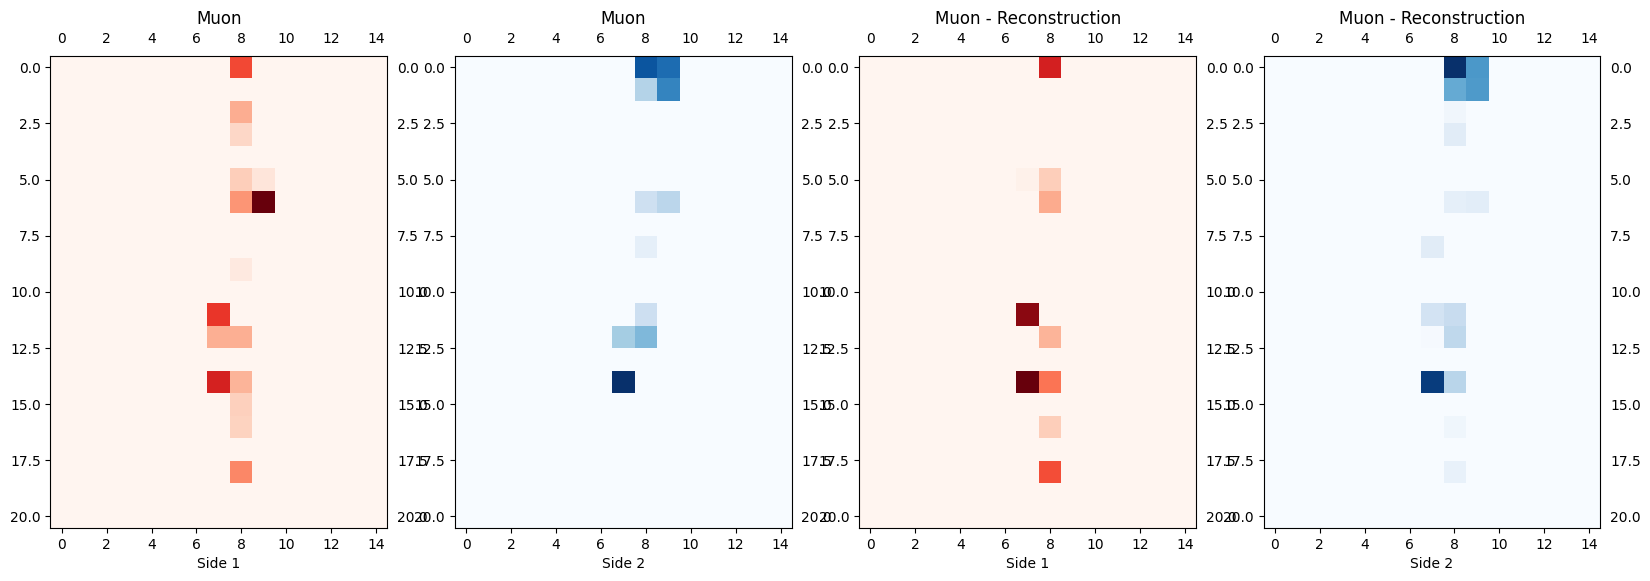

In [11]:
particle_compare_plot(mX_test, autoencoder.predict(mX_test), my_test)

#### Antimuon

32/32 [==============================] - 0s 1ms/step
Event number: [814]


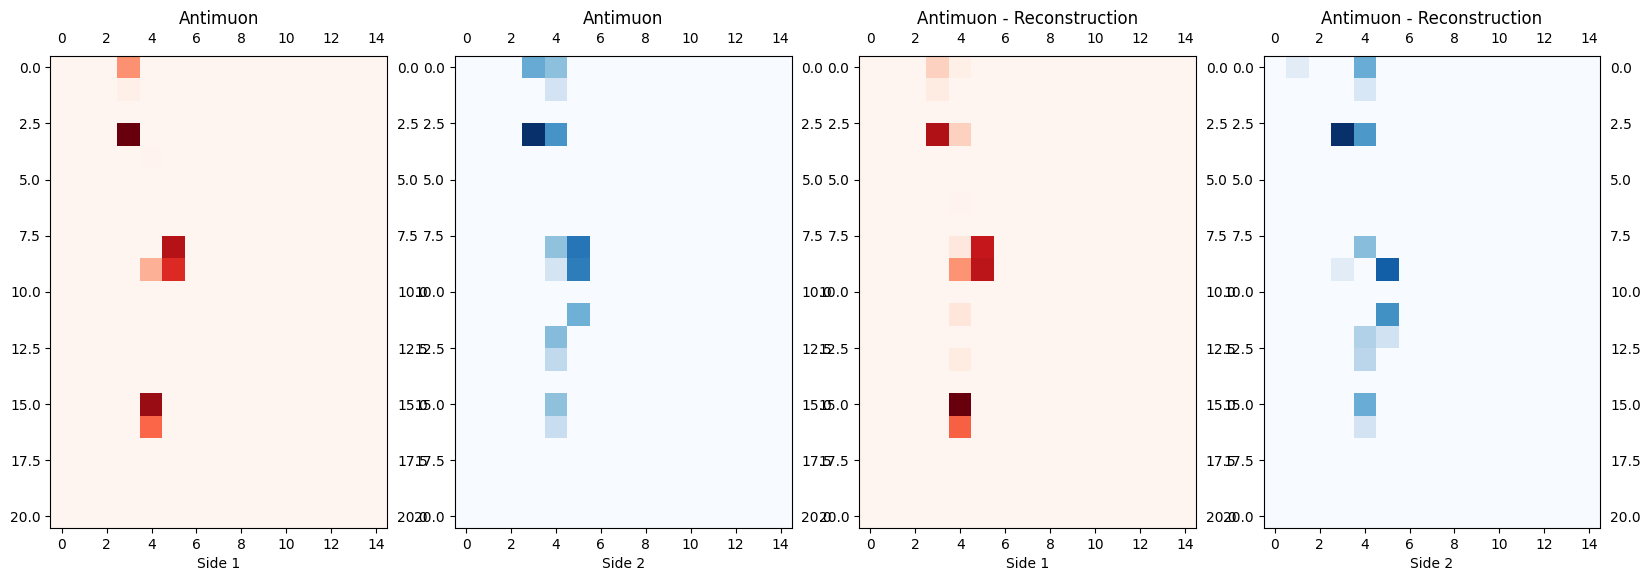

In [12]:
particle_compare_plot(aX_test, autoencoder.predict(aX_test), ay_test)

## Load Data (0.3)

In [13]:
dx = 0.3
dy = 0.3

X, y, nX, ny = load_select_resolution(dx, dy)
mX_train, mX_val, mX_test, my_train, my_val, my_test, aX_train, aX_val, aX_test, ay_train, ay_val, ay_test, nX, ny = tts(X, y, nX, ny, dx, dy)

Matrix shapes -> X: (10167, 7, 5, 2), y: (10167,), nX: (14, 7, 5, 2), ny: (14,)
Muons:
The number of records in the training dataset is 3322
The number of records in the test dataset is 1039
Muon shapes: Train: (3322, 7, 5, 2), Val: (831, 7, 5, 2), Test: (1039, 7, 5, 2), Train labels: (3322, 2), Val labels: (831, 2), Test labels: (1039, 2)
Muon target training vector: [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]
 
 
Antimuons
The number of records in the training dataset is 3184
The number of records in the test dataset is 995
Antimuon shapes: Train: (3184, 7, 5, 2), Val: (796, 7, 5, 2), Test: (995, 7, 5, 2), Train labels: (3184, 2), Val labels: (796, 2), Test labels: (995, 2)
Antimuon target training vector: [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
 
 
Neutrons
Neutron shapes: ((14, 7, 5, 2), (14,))


### Plot random event

[268]


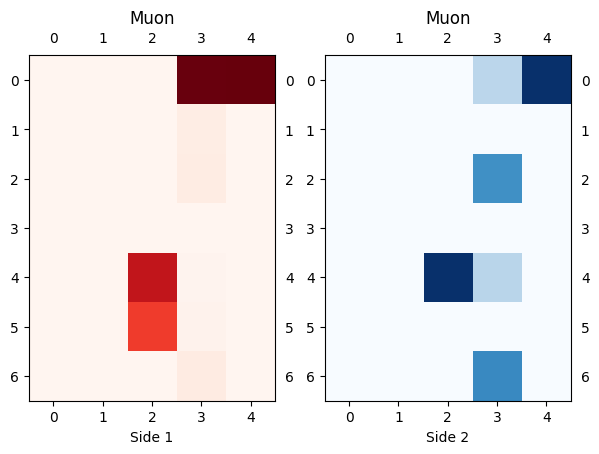

In [14]:
# Plotting a muon event from the training set.
random_events = np.random.randint(0, mX_train.shape[0], 1)
print(random_events)

for i in random_events:
        fig, axs = plt.subplots(1, 2, figsize=(7, 7))
        axs[0].imshow(mX_train[i,:,:,0], cmap='Reds')
        axs[0].set_title('Muon' if my_train[i][0] == 0 else 'Antimuon')
        axs[1].imshow(mX_train[i,:,:,1], cmap='Blues')
        axs[1].set_title('Muon' if my_train[i][0] == 0 else 'Antimuon')
        # Show tick labels on both sides
        axs[0].tick_params('x', labelbottom=True, labeltop=True)
        axs[0].tick_params('y', labelleft=True, labelright=True)
        axs[1].tick_params('x', labelbottom=True, labeltop=True)
        axs[1].tick_params('y', labelleft=True, labelright=True)
        axs[0].set_xlabel('Side 1')
        axs[1].set_xlabel('Side 2')
        
plt.show()

## Autoencoder 1

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 7, 5, 2)]         0         
                                                                 
 sequential_4 (Sequential)   (None, 5)                 7747      
                                                                 
 sequential_5 (Sequential)   (None, 7, 5, 2)           2872      
                                                                 
Total params: 10,619
Trainable params: 10,619
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
104/104 [==============================] - 2s 4ms/step - loss: 0.0355 - accuracy: 0.7105 - val_loss: 0.0308 - val_accuracy: 0.7681
Epoch 2/30
104/104 [==============================] - 0s 2ms/step - loss: 0.0276 - accuracy: 0.7934 - val_loss: 0.0255 - val_accuracy: 0.8128
Epoch 3/30
104/104 [===============

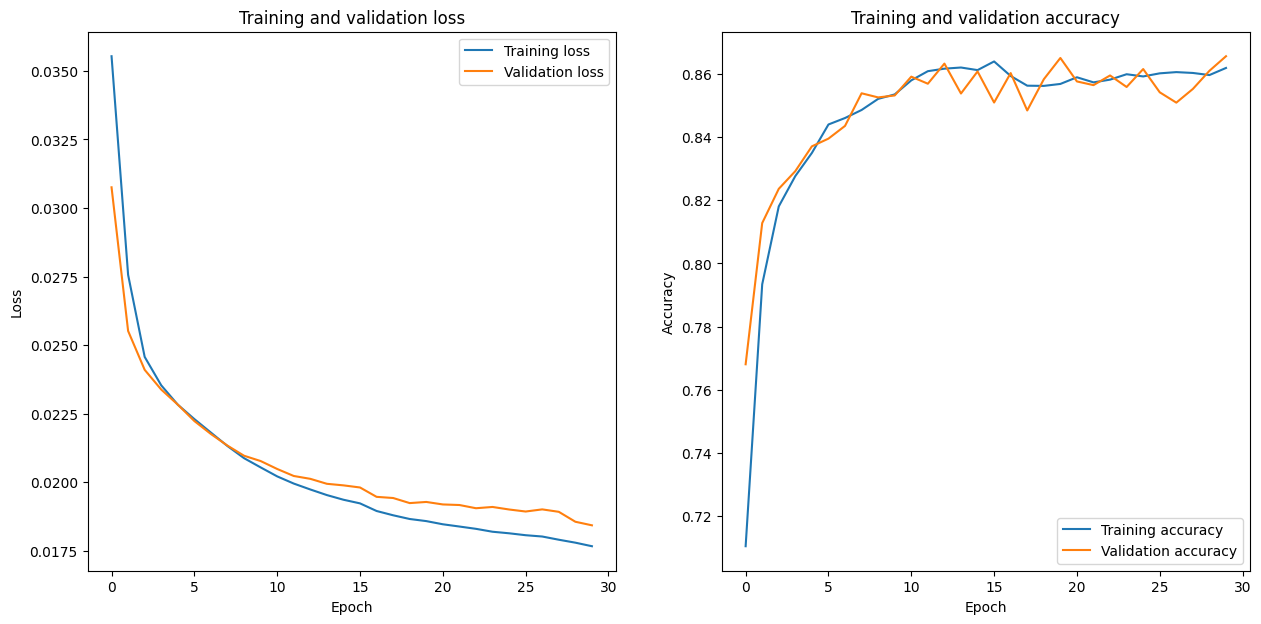

In [15]:
autoencoder = autoencoder_model(mX_train, mX_val, 1)

### MSE Reconstruction Error 1

1/1 [==============================] - 0s 17ms/step


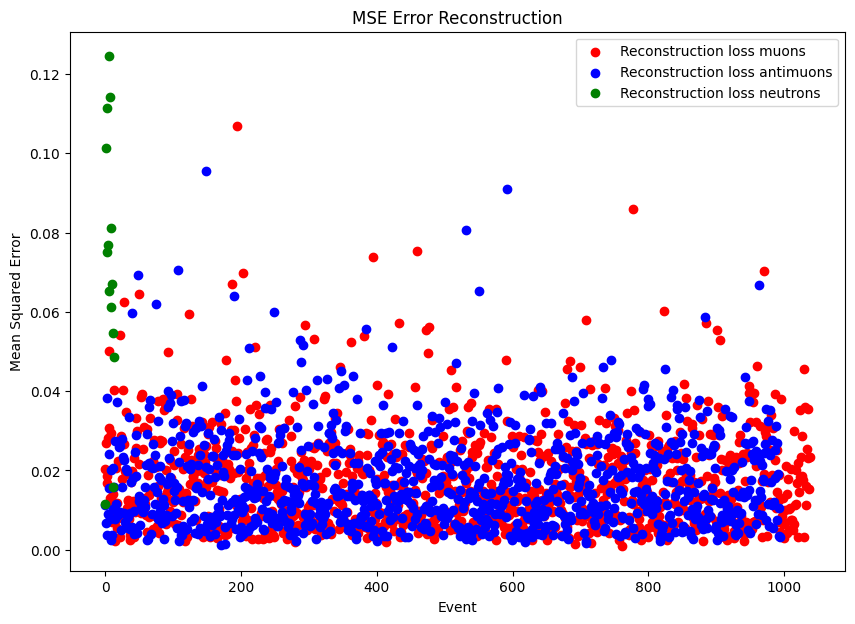

In [16]:
# Plot the difference between the input and the reconstructed output, we want to make sure that data is not separable so we feed the antimuon data to the autoencoder.
# We expect the reconstructed output caused by antimuon data to be non differentiable from the input.
reconstruction_error_plot(autoencoder, mX_test, aX_test, nX)

### Comparing original vs reconstructed particle showers (AE1 0.3)

#### Muon

33/33 [==============================] - 0s 2ms/step
Event number: [109]


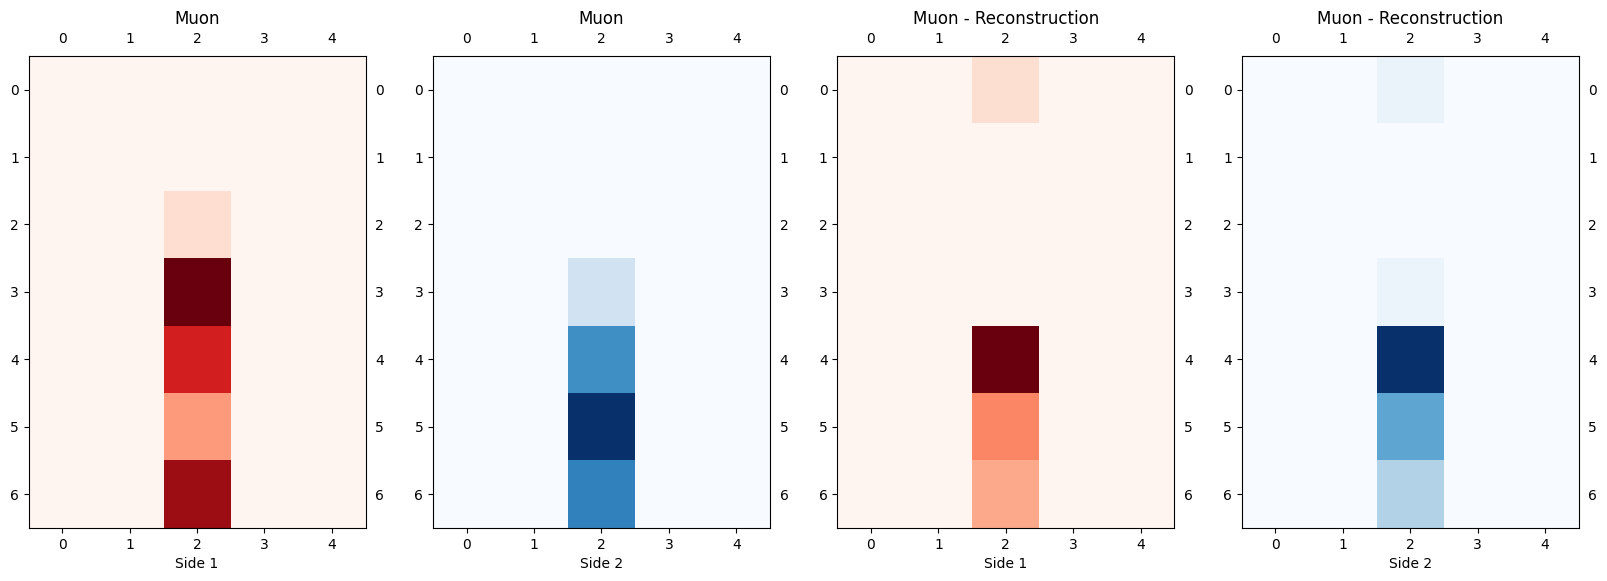

In [17]:
particle_compare_plot(mX_test, autoencoder.predict(mX_test), my_test)

#### Antimuon

32/32 [==============================] - 0s 1ms/step
Event number: [140]


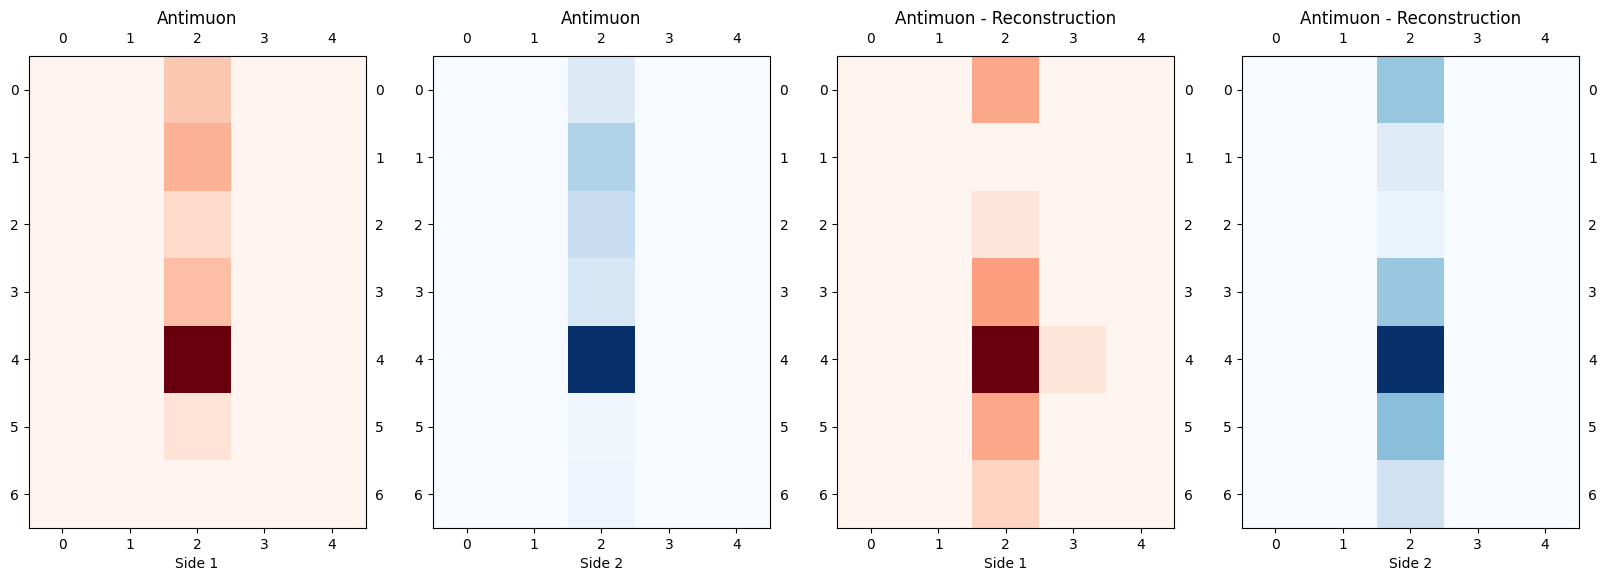

In [18]:
particle_compare_plot(aX_test, autoencoder.predict(aX_test), ay_test)

#### Neutron

1/1 [==============================] - 0s 20ms/step
Event number: [2]


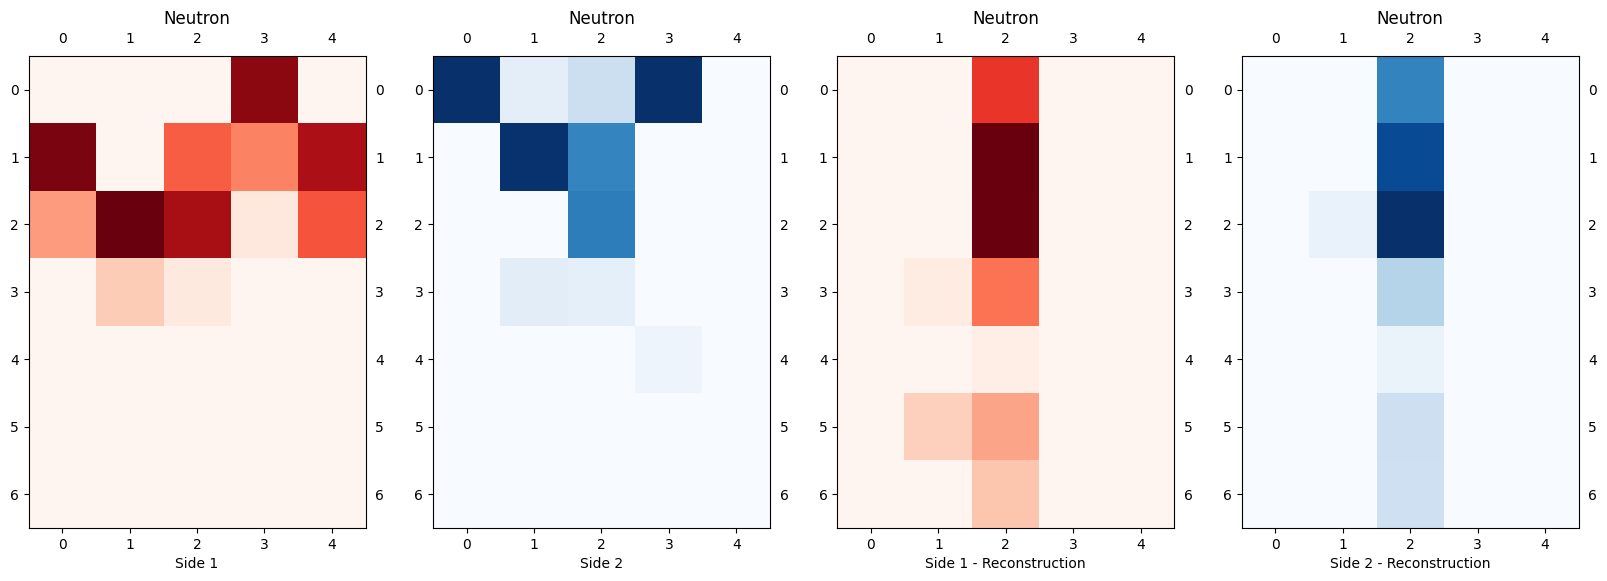

In [19]:
particle_compare_plot(nX, autoencoder.predict(nX))

## Autoencoder 2

KerasTensor(type_spec=TensorSpec(shape=(None, 7, 5, 2), dtype=tf.float32, name='input_7'), name='input_7', description="created by layer 'input_7'")
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 7, 5, 2)]         0         
                                                                 
 sequential_6 (Sequential)   (None, 32)                2272      
                                                                 
 sequential_7 (Sequential)   (None, 7, 5, 2)           2310      
                                                                 
Total params: 4,582
Trainable params: 4,582
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
104/104 [==============================] - 1s 3ms/step - loss: 0.0321 - accuracy: 0.7116 - val_loss: 0.0222 - val_accuracy: 0.7714
Epoch 2/30
104/104 [=====

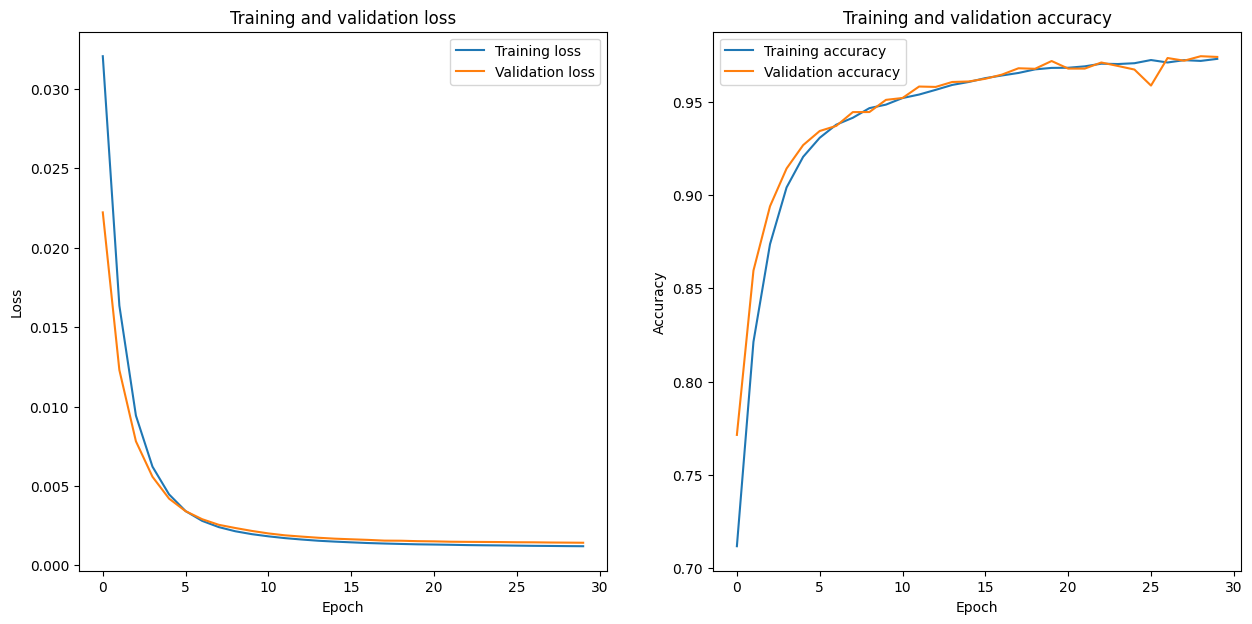

In [20]:
autoencoder = autoencoder_model(mX_train, mX_val, 2)

### MSE Reconstruction Error 2

1/1 [==============================] - 0s 17ms/step


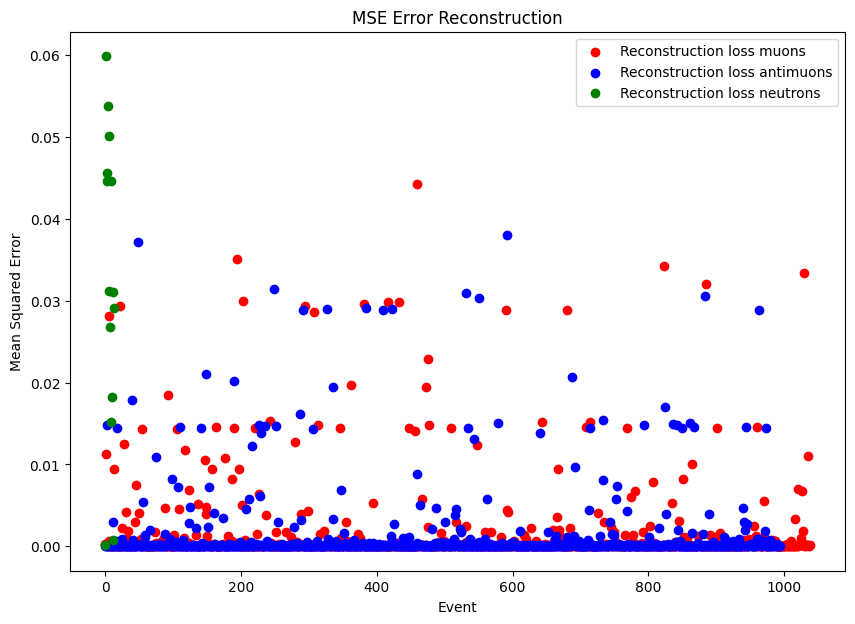

In [21]:
reconstruction_error_plot(autoencoder, mX_test, aX_test, nX)

### Comparing original vs reconstructed particle showers (AE2 0.3)

#### Muon

 1/33 [..............................] - ETA: 0s

33/33 [==============================] - 0s 2ms/step
Event number: [154]


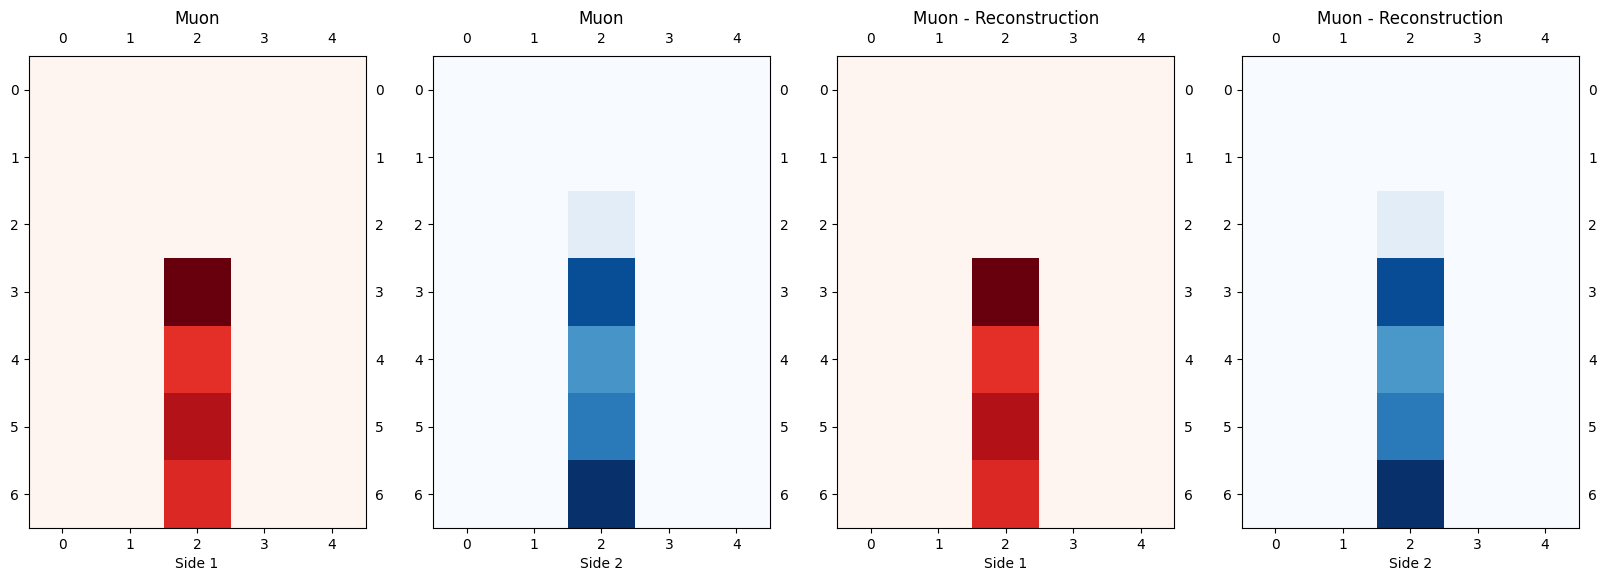

In [22]:
particle_compare_plot(mX_test, autoencoder.predict(mX_test), my_test)

#### Antimuon

32/32 [==============================] - 0s 1ms/step
Event number: [882]


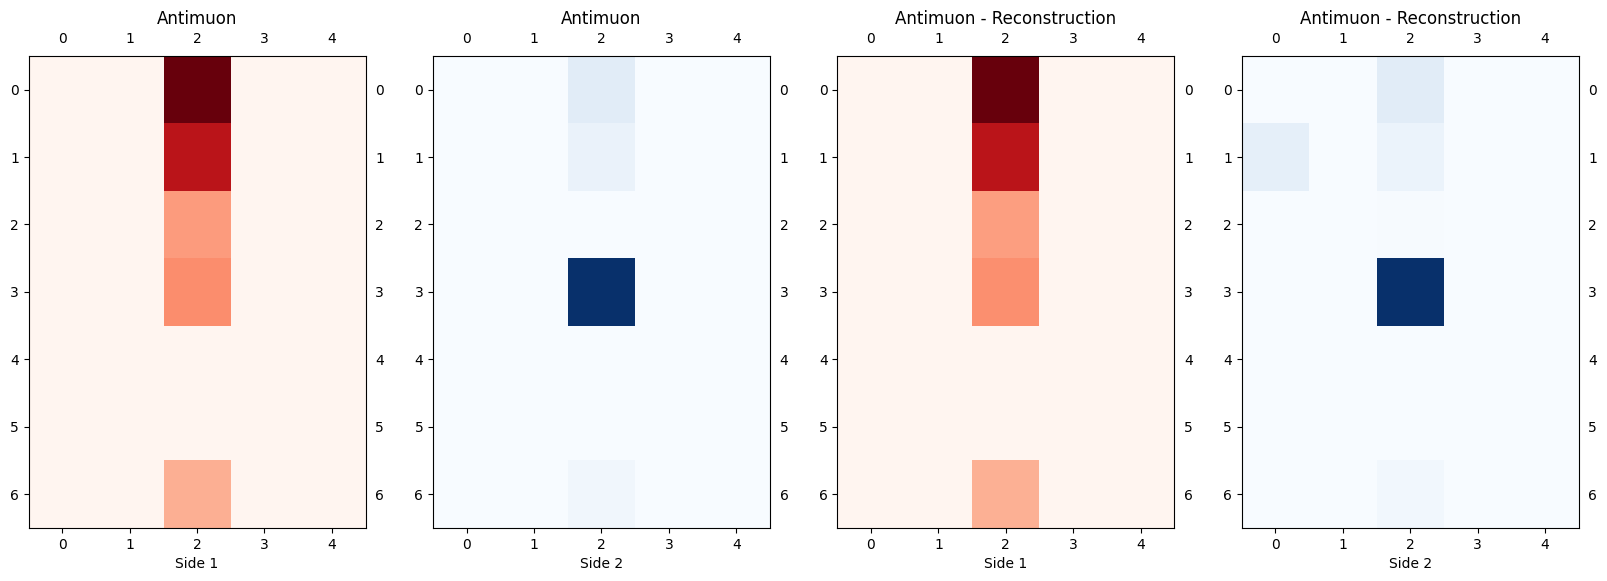

In [23]:
particle_compare_plot(aX_test, autoencoder.predict(aX_test), ay_test)

#### Neutron

1/1 [==============================] - 0s 19ms/step


Event number: [3]


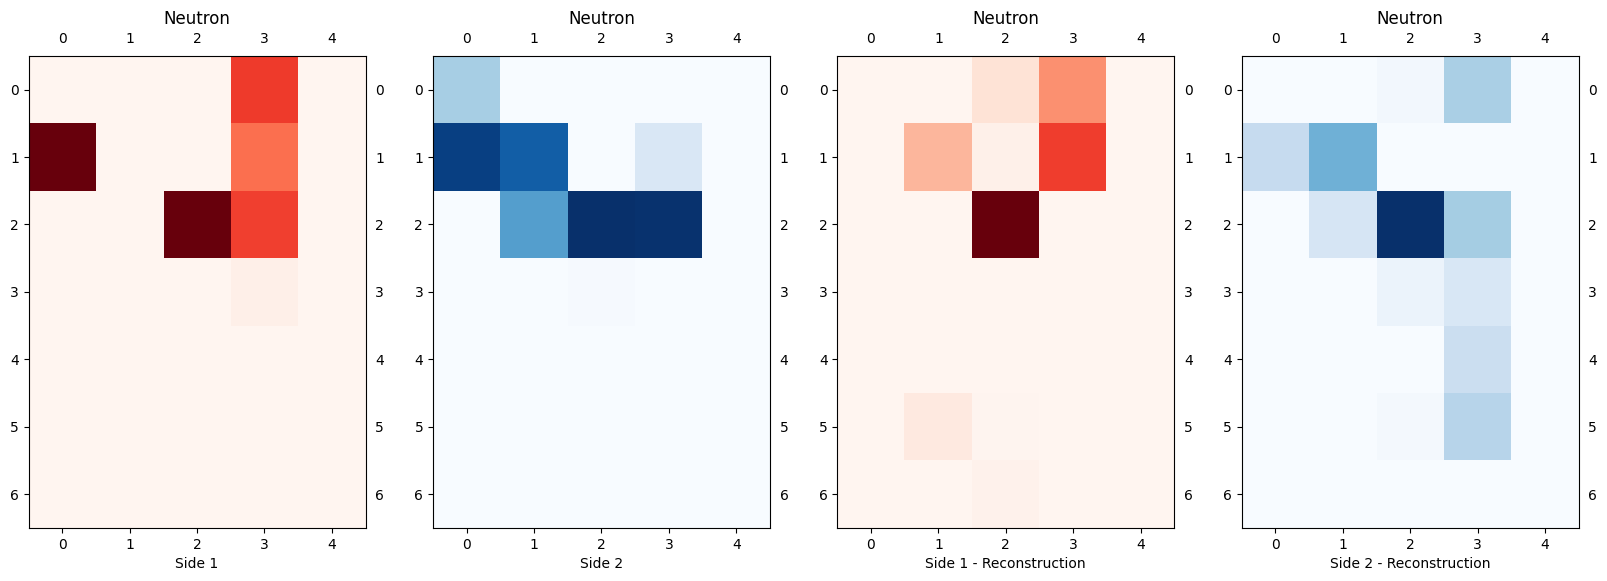

In [24]:
particle_compare_plot(nX, autoencoder.predict(nX))